In [1]:
import pandas as pd
from os import path, listdir, mkdir
import numpy as np
from scipy import stats
import statsmodels.sandbox.stats.multicomp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import mannwhitneyu

In [10]:
# sample_groups = [['3821a', '3821K'],
#                  ['4114a', '4114K'],
#                  ['5522a', '5522K'],
#                  ['6067a', '6067K'],
#                  ['ANa', 'ANK']]


# sample_groups = [['4_A', '4_K'],
#                  ['24_A', '24_K'],
#                  ['48_A', '48_K']] 

# sample_groups = [['4_G', '4_K'],
#                  ['24_G', '24_K'],
#                  ['48_G', '48_K']]

# sample_groups = [['i_A', 'i_K'], 
#                  ['b_A', 'b_K']]

# sample_groups = [['i_B', 'i_K'], 
#                  ['b_B', 'b_K']]

sample_groups = [['DBTRG_I', 'DBTRG_K'], 
                 ['A172_I', 'A172_K']]


In [18]:
def stat_test(input_dir, output_dir, nsaf_data_name, sample_file, 
              alpha = 0.05, stattest = 'ttest_ind'):
    
    tmp_dict = {}
    sns.set(style = 'whitegrid')
    s_file = pd.read_csv(sample_file, index_col = 'File Name', header = 0)
    
    for sample_type in sample_groups:
        df = pd.DataFrame()
        s1 = pd.DataFrame()
        s2 = pd.DataFrame()
        MV_df = pd.DataFrame()
        
        control_group = sample_type[1]
        sample_name = sample_type[0]
            
        output = path.join(output_dir, 'MinDet')
        
        if path.exists(output) == False:
            mkdir(output)
        
        for filename in listdir(input_dir):
            bool_id = False
            
            file_id = filename.split('_identipy')[0].split('_protein_groups.tsv')[0]
            bool_id = '_protein_groups.tsv' in filename
                
            if (bool_id) and (file_id in s_file.index):
                s_type = s_file.loc[file_id, 'SampleID']
                if s_type in sample_type:
                    d = pd.read_csv(path.join(input_dir, filename), delimiter = '\t')
                    d['Protein'] = d['dbname'] + ' ' + d['description']

                    data_name = file_id + '/' + s_type 
                    d.set_index(d['Protein'], inplace = True)
                    d.rename(columns = {'NSAF': data_name}, inplace = True)

                    df = pd.concat([df, d[data_name]], axis = 1)
                    
        for col in df.columns:
            if control_group in col.split('/')[1]:
                s1[col] = df[col].copy(deep = True)
            else:
                s2[col] = df[col].copy(deep = True)      
        print(s1.columns, '\n', s2.columns)
    
        df['% NaNs'] = df.isna().sum(axis = 1)/len(df.columns)
        MV = np.mean(df['% NaNs'].values)
           
        s1_dict = {}
        for col in s1.columns:
            s1[col] = s1[col].apply(lambda x: np.log2(x))
            median = s1[col].median(axis = 0, skipna  = True)
            std = s1[col].std(axis = 0, skipna = True)
            s1[col] = s1[col].apply(lambda x: (x - median)/std)
            s1_dict[col] = s1[col].count()
        
        s1['% NaN'] = s1.isna().sum(axis = 1)/len(s1.columns)
        g = sns.histplot(data = s1, x = '% NaN', kde = True, bins = len(s1.columns))
        g.set_title('% NaN control group {} {}'.format(nsaf_data_name, sample_name))
        g.set_xticks(np.arange(0, 1, 0.1))
        plt.show()
        g.get_figure().savefig(path.join(output, '{} {} % NaN distribution control.png'.format(nsaf_data_name, sample_name)), 
                               dpi = 300, format = 'svg')
        plt.close() 
        drop_list_proteins_s1 = s1[s1['% NaN'] >= 0.5].index
        
        s2_dict = {}
        for col in s2.columns:
            s2[col] = s2[col].apply(lambda x: np.log2(x))
            median = s2[col].median(axis = 0, skipna = True)
            std = s2[col].std(axis = 0, skipna = True)
            s2[col] = s2[col].apply(lambda x: (x - median)/std)
            s2_dict[col] = s2[col].count()
            
        s2['% NaN'] = s2.isna().sum(axis = 1)/len(s2.columns) 
        g = sns.histplot(data = s2, x = '% NaN', kde = True, bins = len(s2.columns))
        g.set_title('% NaN stress group {} {}'.format(nsaf_data_name, sample_name))
        g.set_xticks(np.arange(0, 1, 0.1))
        plt.show()
        g.get_figure().savefig(path.join(output, '{} {} % NaN distribution stress'.format(nsaf_data_name, sample_name)), 
                               dpi = 300)
        plt.close() 
        drop_list_proteins_s2 = s2[s2['% NaN'] >= 0.5].index
        
        drop_list_proteins = drop_list_proteins_s1.intersection(drop_list_proteins_s2)
        print('{} proteins are dropped'.format(len(drop_list_proteins)))
       
        s1.drop(labels = drop_list_proteins, axis = 0, inplace = True)
        s1[s1['% NaN'] == 1].to_csv(path.join(output, 'absent_prots_control_{}_{}.tsv'.format(nsaf_data_name, sample_name)), 
                                    sep = '\t')
        s1.drop(labels = ['% NaN'], axis = 1, inplace = True)
        
        s2.drop(labels = drop_list_proteins, axis = 0, inplace = True)
        s2[s2['% NaN'] == 1].to_csv(path.join(output, 'absent_prots_stress_{}_{}.tsv'.format(nsaf_data_name, sample_name)), 
                                                                                         sep = '\t')
        s2.drop(labels = ['% NaN'], axis = 1, inplace = True)
        
        for col in s1.columns:
            MV_df.loc[col, 'percent'] = s1[col].isna().sum(axis = 0)/len(s1[col])
        control_mv_mean = MV_df[~MV_df.isin(s1)].dropna().mean(axis = 0)
        
        for col in s2.columns:
            MV_df.loc[col, 'percent'] = s2[col].isna().sum(axis = 0)/len(s2[col])
        stress_mv_mean = MV_df[~MV_df.isin(s2)].dropna().mean(axis = 0)
      
        s1.fillna(s1.min(axis = 0), axis = 0, inplace = True)    
        s2.fillna(s2.min(axis = 0), axis = 0, inplace = True)
        
        s1['SW_pval'] = s1.apply(lambda x: stats.shapiro(x).pvalue, axis = 1)
        s1_SW_pval = s1['SW_pval'].copy(deep =  True)
        sw_proteins_list_s1 = s1[s1['SW_pval'] < 0.05].index.copy(deep = True)
        Ns1 = s1[s1['SW_pval'] < 0.05].shape[0]/s1.shape[0]
        
        g = sns.histplot(data = s1, x = 'SW_pval', kde = True, stat = 'percent')
        g.set_title('Shapiro-Wilk p-value control group {} {}'.format(nsaf_data_name, sample_name))
        g.set_xticks(np.arange(0, 1, 0.1))
        plt.text(s = '{} % hypotheses rejected'.format(round(100*Ns1)), y = 10, x = 0.5)
        plt.show()
        g.get_figure().savefig(path.join(output, '{} {} SW pval control'.format(nsaf_data_name, sample_name)), 
                               dpi = 300)
        plt.close() 
        s1.drop(labels = ['SW_pval'], axis = 1, inplace = True)
        
        s2['SW_pval'] = s2.apply(lambda x: stats.shapiro(x).pvalue, axis = 1)
        s2_SW_pval = s2['SW_pval'].copy(deep = True)
        sw_proteins_list_s2 = s2[s2['SW_pval'] < 0.05].index.copy(deep = True)
        Ns2 = s2[s2['SW_pval'] < 0.05].shape[0]/s2.shape[0]
        
        g = sns.histplot(data = s2, x = 'SW_pval', kde = True, stat = 'percent')
        g.set_title('Shapiro-Wilk p-value stress group {} {}'.format(nsaf_data_name, sample_name))
        g.set_xticks(np.arange(0, 1, 0.1))
        plt.text(s =  '{} % hypotheses rejected'.format(round(100*Ns2)), y = 10, x = 0.5)
        plt.show()
        g.get_figure().savefig(path.join(output, '{} {} SW pval stress'.format(nsaf_data_name, sample_name)), 
                               dpi = 300)
        plt.close() 
        s2.drop(labels = ['SW_pval'], axis = 1, inplace = True)
        
        sw_proteins_list = list(set([*sw_proteins_list_s1, *sw_proteins_list_s2]))
        
        s1 = s1.sort_index()
        s2 = s2.sort_index()
        
        tmp_s1 = s1.loc[sw_proteins_list].values.tolist()
        tmp_s2 = s2.loc[sw_proteins_list].values.tolist()
        
        MW_pval = pd.Series(data = [mannwhitneyu(row1, row2)[1] for row1, row2 in zip(tmp_s1, tmp_s2)], 
                            index = sw_proteins_list)
        
        tmp = s1.index
        s1 = s1[s1.index.isin(s2.index)]
        s2 = s2[s2.index.isin(tmp)]
     
        rows = len(s1.columns) // 3 + 1*(len(s1.columns) % 3 != 0)
        fig, axs = plt.subplots(rows, 3, figsize = (15, rows*2.7), squeeze = False)
        fig.suptitle('%s %s control %d %% mv' % (nsaf_data_name, sample_name, round(100*control_mv_mean)))
        fig.subplots_adjust(hspace = .5, wspace = .5, top = 0.95) 
        axs = axs.ravel() 
        
        i = 0
        for col in s1.columns:
            tmp = sns.histplot(data = s1, ax = axs[i], x = col, kde = True)
            tmp.set_xlabel(col, fontsize = 12)
            axs[i].text(0.1, 0.78, '{} % mv \n{} identifications'.format(round(100*MV_df.loc[col, 'percent']), s1_dict[col]), 
                        transform = axs[i].transAxes, fontsize = 11)
            i+=1
        for j in range(i, rows*3):
            fig.delaxes(axs.flatten()[j])
            
        fig.savefig(path.join(output, '{}_{}_hists_control.png'.format(nsaf_data_name, sample_name)), dpi = 300)
        
        plt.close()
        
        rows = len(s2.columns) // 3 + 1*(len(s2.columns) % 3 != 0)
        fig, axs = plt.subplots(rows, 3, figsize = (15, rows*2.7), squeeze = False)
        fig.suptitle('%s %s stress %d %% mv' % (nsaf_data_name, sample_name, round(100*stress_mv_mean)))
        fig.subplots_adjust(hspace = .5, wspace = .5, top = 0.95) 
        axs = axs.ravel() 
        
        i = 0
        for col in s2.columns:
            tmp = sns.histplot(data = s2, ax = axs[i], x = col, kde = True)
            tmp.set_xlabel(col, fontsize = 12)
            axs[i].text(0.1, 0.78, '{} % mv \n{} identifications'.format(round(100*MV_df.loc[col, 'percent']), s2_dict[col]), 
                        transform = axs[i].transAxes, fontsize = 11)
            i+=1
        for j in range(i, rows*3):
            fig.delaxes(axs.flatten()[j])
            
        fig.savefig(path.join(output, '{}_{}_hists_stress.png'.format(nsaf_data_name, sample_name)), dpi = 300)
        
        plt.close()
        
        s1_stat = s1.values.tolist()
        s2_stat = s2.values.tolist()
        print(len(s1_stat), len(s2_stat))

        if stattest == 'ttest_ind':
            pval = pd.Series(data = [stats.ttest_ind(row1, row2)[1] for row1, row2 in zip(s1_stat, s2_stat)], index = s1.index)
        if stattest == 'ttest_rel':
            pval = pd.Series(data = [stats.ttest_rel(row1, row2)[1] for row1, row2 in zip(s1_stat, s2_stat)], index = s1.index)

        new_df = pd.merge(s1, s2, left_index=True, right_index=True)
        new_df['pval'] = pval
        new_df = new_df.dropna(axis = 0, subset = ['pval'])

        new_df['fdr_BH'] = statsmodels.sandbox.stats.multicomp.multipletests(new_df['pval'], 
                                                                         method = 'fdr_bh', alpha = alpha)[1]
        new_df['Protein'] = new_df.index
        new_df['ProteinID'] = new_df.Protein.apply(lambda x: x.split('|')[1])
        new_df['Gene'] = new_df.Protein.astype(str).apply(lambda x: x.split('GN=')[1].split(' ')[0] 
                                                              if 'GN=' in x else x.split(' ')[0])
        new_df.drop(labels = ['Protein'], axis = 1, inplace = True)
        new_df['-log10(fdr_BH)'] = new_df['fdr_BH'].apply(lambda x: -np.log10(x))
        new_df['log2(fold_change)'] = s2.mean(axis = 1) - s1.mean(axis = 1)
        
        control_col_name = sample_type[0] + '_SW_pval'
        stress_col_name = sample_type[1] + '_SW_pval'
        
        new_df[control_col_name] = s1_SW_pval
        new_df[stress_col_name] = s2_SW_pval
        
        new_df['MW_pval'] = MW_pval
        
        fdr_MW_df = new_df[new_df['MW_pval'].notna() == True].MW_pval
        fdr_MW = statsmodels.sandbox.stats.multicomp.multipletests(fdr_MW_df, 
                                                                         method = 'fdr_bh', alpha = alpha)[1]
        new_df['fdr_BH_MW'] = pd.Series(data = fdr_MW, index = fdr_MW_df.index)
        
        
        new_df.to_csv(path.join(output, 'NSAF_t-test_{}_{}.tsv'.format(nsaf_data_name, sample_name)), 
                                                                                         sep = '\t')
        
        tmp_dict['{}_{}'.format(nsaf_data_name, sample_name)] = [MV, Ns1, Ns2]
        MV_df.to_csv(path.join(output, 'MV_stat_{}_{}.csv'.format(nsaf_data_name, sample_name)), sep = '\t')
        

Index(['LUM00926_VG/DBTRG_K', 'LUM00938_VG/DBTRG_K', 'LUM00929_VG/DBTRG_K',
       'LUM00935_VG/DBTRG_K', 'LUM00937_VG/DBTRG_K', 'LUM00936_VG/DBTRG_K',
       'LUM00939_VG/DBTRG_K', 'LUM00928_VG/DBTRG_K', 'LUM00925_VG/DBTRG_K',
       'LUM00927_VG_160910015530/DBTRG_K'],
      dtype='object') 
 Index(['LUM00943_VG/DBTRG_I', 'LUM00931_VG/DBTRG_I', 'LUM00933_VG/DBTRG_I',
       'LUM00932_VG/DBTRG_I', 'LUM00930_VG/DBTRG_I', 'LUM00944_VG/DBTRG_I',
       'LUM00941_VG/DBTRG_I', 'LUM00934_VG/DBTRG_I', 'LUM00942_VG/DBTRG_I',
       'LUM00940_VG/DBTRG_I'],
      dtype='object')


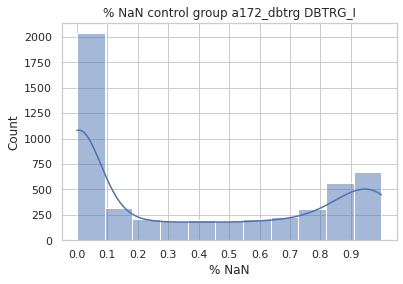

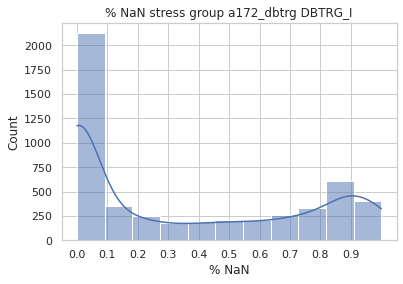

1792 proteins are dropped


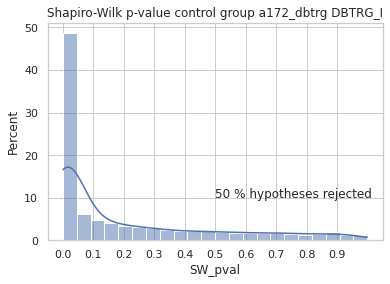

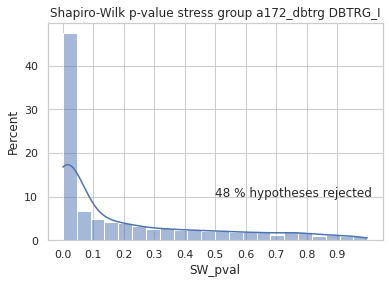

3332 3332
Index(['LUM00981_VG/A172_K', 'LUM00972_VG/A172_K', 'LUM00978_VG/A172_K',
       'LUM00970_VG/A172_K', 'LUM00969_VG/A172_K', 'LUM00980_VG/A172_K',
       'LUM00968_VG/A172_K', 'LUM00982_VG/A172_K', 'LUM00971_VG/A172_K',
       'LUM00979_VG/A172_K'],
      dtype='object') 
 Index(['LUM00973_VG/A172_I', 'LUM00975_VG/A172_I', 'LUM00983_VG/A172_I',
       'LUM00977_VG/A172_I', 'LUM00976_VG/A172_I', 'LUM00974_VG/A172_I',
       'LUM00984_VG/A172_I', 'LUM00987_VG/A172_I', 'LUM00986_VG/A172_I'],
      dtype='object')


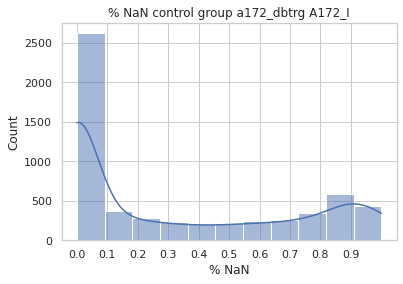

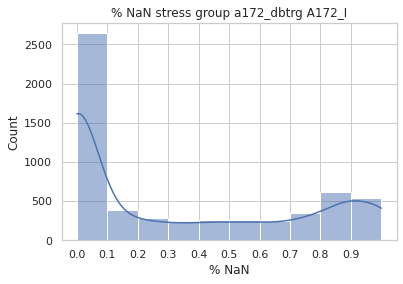

1748 proteins are dropped


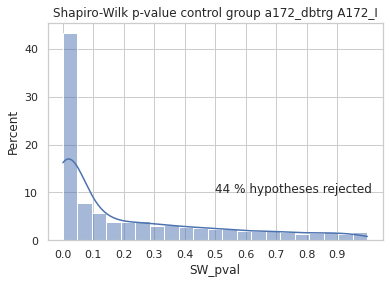

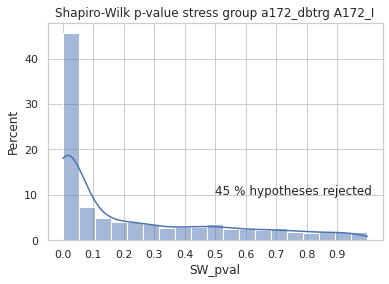

4052 4052


In [19]:
stat_test(input_dir = 'example/input_stattest',
          output_dir = 'example/output_stattest', nsaf_data_name = 'a172_dbtrg',
          sample_file = 'example/input_stattest/a172_dbtrg_sample.csv',
          stattest = 'ttest_ind')